
# MSIT 3103 — Assignment 4 Hotstart Notebook



## 0. Environment Setup (Run Once)
If you are running locally and missing packages, uncomment the `pip` cell below.

- Python ≥ 3.9
- `torch`, `numpy`, `matplotlib`, `tqdm`, `nltk`, `pandas` (optional: `datasets` for WikiText-2)


In [ ]:

%pip install torch numpy matplotlib tqdm nltk pandas datasets --quiet

import math
import os
import random
import time
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")


Note: you may need to restart the kernel to use updated packages.



## 1. Config
Tweak these as you experiment. Keep them **small** for faster iterations.


In [ ]:

@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    # data
    use_builtin_tiny_corpus: bool = True  # if False, tries tiny wikitext-2 via datasets
    context_len: int = 64
    train_frac: float = 0.9
    # model
    vocab_size: int = 0  # filled after building tokenizer
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    # optimization
    batch_size: int = 64
    lr: float = 3e-3
    max_steps_pretrain: int = 1000
    max_steps_sft: int = 1000
    max_steps_rl: int = 200  # tiny on purpose
    eval_every: int = 50
    # generation
    temperature: float = 0.9
    top_k: Optional[int] = 50

CFG = Config()
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

CFG.device


'cpu'


## 2. Data: Tiny Corpus + Optional Synthetic
We use a tiny **public-domain** text for **pre-training** and **validation**.  
For **SFT**, we create a micro instruction-like dataset.

You can switch to `datasets` (WikiText-2) by setting `CFG.use_builtin_tiny_corpus=False`.


In [ ]:

BUILTIN_TINY_TEXT = "From fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed'st thy light'st flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThy self thy foe, to thy sweet self too cruel:"

def load_corpus(use_builtin: bool = True) -> str:
    """Return a small training corpus."""
    if use_builtin:
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            # concatenate first N lines to keep it tiny
            lines = ds['train']['text'][:200]
            return "\n".join([l for l in lines if l is not None]).strip()
        except Exception as e:
            print("Falling back to builtin tiny text due to:", e)
            return BUILTIN_TINY_TEXT.strip()

# corpus_text = load_corpus(use_builtin = True)
corpus_text = load_corpus(use_builtin = False)

print(corpus_text[:300], "...")


= Valkyria Chronicles III = 


 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStat ...



### 2.1 Character Tokenizer
A simple **character-level** tokenizer keeps things very light-weight.


In [ ]:

class CharTokenizer:
    def __init__(self, text: str):
        vocab = sorted(set(text))
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(vocab)

    def encode(self, s: str) -> List[int]:
        return [self.stoi[c] for c in s if c in self.stoi]

    def decode(self, ids: List[int]) -> str:
        return "".join(self.itos[i] for i in ids)

tokenizer = CharTokenizer(corpus_text)
CFG.vocab_size = tokenizer.vocab_size
print(f"CFG.vocab_size: {CFG.vocab_size}")

# Update the top_k based on vocab size
CFG.top_k = min(50, CFG.vocab_size) # ensure top_k is not greater than vocab_size
print(f"CFG.top_k: {CFG.top_k}")


CFG.vocab_size: 131
CFG.top_k: 50



### 2.2 Dataset & DataLoader
We build tiny (input, target) pairs for next-char prediction.


In [ ]:

class LMDataset(Dataset):
    def __init__(self, text: str, tokenizer: CharTokenizer, context_len: int = 64, split: str = "train", train_frac: float = 0.9):
        enc = tokenizer.encode(text)
        n = int(len(enc) * train_frac)
        if split == "train":
            self.data = enc[:n]
        else:
            self.data = enc[n:]
        self.context_len = context_len

    def __len__(self):
        return max(0, len(self.data) - self.context_len - 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.context_len]
        y = self.data[idx+1:idx+self.context_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

train_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
val_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "val", CFG.train_frac)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

len(train_ds), len(val_ds)


(49757, 5471)


## 3. Model: Tiny GPT-like (Character-level)
Small causal self-attention stack for quick experiments.


In [ ]:

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.blocks = nn.ModuleList([Block(d_model, n_heads, dropout, context_len) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

        # init
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, V)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=128, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -CFG.context_len:]
            logits, _ = self.forward(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-8)
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                mask = logits < v[:, [-1]]
                logits[mask] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx



## 4. Utilities: Evaluation & Plotting


In [ ]:
def eval_loss(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            _, loss = model(x, y)
            losses.append(loss.item())
    model.train()
    return float(np.mean(losses)) if losses else float('nan')

def perplexity(loss_val: float) -> float:
    try:
        return float(math.exp(loss_val))
    except OverflowError:
        return float('inf')

def sample_text(model, prompt: str, max_new_tokens=128):
    model.eval()
    inp = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=CFG.device)
    out = model.generate(inp, max_new_tokens=max_new_tokens, temperature=CFG.temperature, top_k=CFG.top_k)
    return tokenizer.decode(out[0].tolist())

def plot_losses(train_losses, val_losses, title="Training Curves"):
    plt.figure(figsize=(10, 6))
    xs = list(range(len(train_losses)))

    # Plot with enhanced styling
    plt.plot(xs, train_losses, label="Train Loss", linewidth=2.5, color='#1f77b4', alpha=0.8)
    if val_losses:
        plt.plot(xs, val_losses, label="Validation Loss", linewidth=2.5, color='#ff7f0e', alpha=0.8)

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(f"Evaluation Step (every {CFG.eval_every} training steps)", fontsize=12)
    plt.ylabel("Loss", fontsize=12)

    # Add grid and styling
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=11, framealpha=0.9)

    # Set background color and improve layout
    plt.gca().set_facecolor('#f8f9fa')
    plt.tight_layout()

    # Add some statistics as text
    if train_losses:
        final_train = train_losses[-1]
        plt.text(0.02, 0.98, f'Final Train Loss: {final_train:.4f}',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    if val_losses:
        final_val = val_losses[-1]
        plt.text(0.02, 0.88, f'Final Val Loss: {final_val:.4f}\nPerplexity: {perplexity(final_val):.2f}',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()



## 5. Pre-training (Unsupervised LM)
Train the tiny GPT on the tiny corpus with next-character prediction.


Pre-training:   0%|          | 0/1000 [00:36<?, ?it/s, loss=2.84, val_loss=2.85]

Pre-training:   0%|          | 0/1000 [01:55<?, ?it/s, loss=1.69, val_loss=2]



Pre-train done. Train loss ~ 1.6864243745803833  Val loss ~ 1.9950145398869235  PPL ~ 7.352309928868622


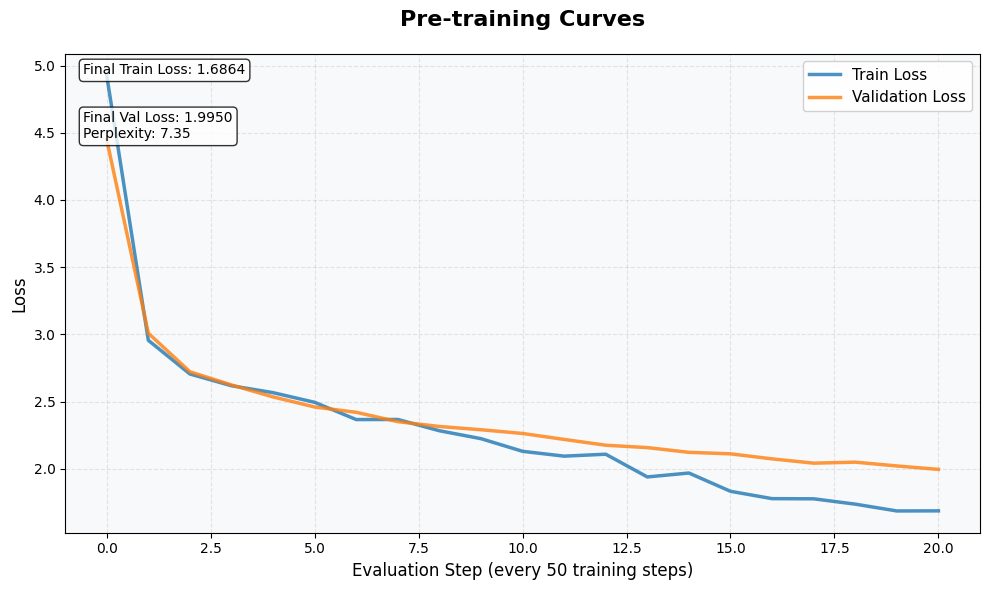

To beginn , alound her att " of the urice in . 

 Labe State Na ) 4 Requal " , the Purtean in 

 = = Macgeity PorthyState in 


In [ ]:

model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))



## 6. Supervised Fine-Tuning (SFT)
We create a **tiny instruction-like dataset** of (prompt → completion).  
We then **continue training** the pre-trained model on these pairs (next-token loss).

> Tip: Replace `SFT_PAIRS` with your own pairs to study transfer.


SFT training text preview (first 400 chars):
 Instruction: Write a short motto about learning:\nAnswer: Learn, iterate, and grow.\n\nInstruction: Summarize: 'Neural nets learn patterns'.\nAnswer: They learn patterns by adjusting weights.\n\nInstruction: Give a creative tagline for coffee:\nAnswer: Sip ideas. Brew brilliance.\n\nInstruction: Explain: What is perplexity (1 sentence)?\nAnswer: A measure of how well a language model predicts a sample.\n\n ...



SFT:   0%|          | 0/1000 [01:12<?, ?it/s, loss=0.0474, val_loss=nan]

SFT done. Train loss ~ 0.04740696772933006  Val loss ~ nan  PPL ~ nan


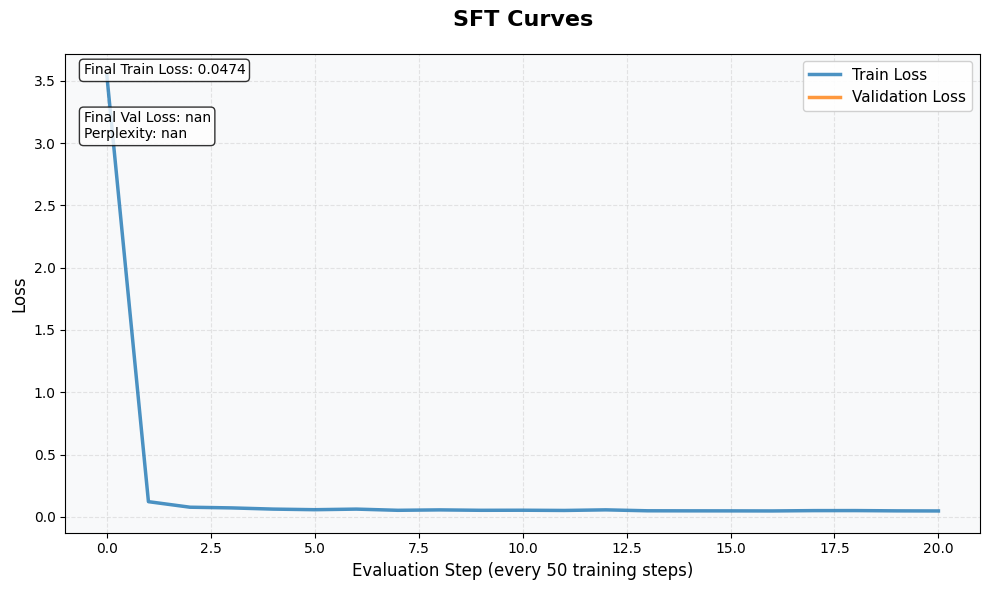


Per-pair comparison (pre-trained -> after SFT) with BLEU scores:

Pair 1: Write a short motto about learning:
Reference:  Learn, iterate, and grow.
-- Before SFT (pre-trained):
" Mare Rechol in Delotoreved und to wordn nume , ass conver . Federal to herefa
BLEU(before) = 0.0146
-- After SFT:
Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'
BLEU(after)  = 0.3724
------------------------------------------------------------
Pair 1: Write a short motto about learning:
Reference:  Learn, iterate, and grow.
-- Before SFT (pre-trained):
" Mare Rechol in Delotoreved und to wordn nume , ass conver . Federal to herefa
BLEU(before) = 0.0146
-- After SFT:
Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'
BLEU(after)  = 0.3724
------------------------------------------------------------
Pair 2: Summarize: 'Neural nets learn patterns'.
Reference:  They learn patterns by adjusting weights.
-- Before SFT (pre-trained):
while story the Littl

In [ ]:
# Diverse SFT pairs and improved before/after comparison with BLEU
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

SFT_PAIRS = [
    ("Write a short motto about learning:", " Learn, iterate, and grow."),
    ("Summarize: 'Neural nets learn patterns'.", " They learn patterns by adjusting weights."),
    ("Give a creative tagline for coffee:", " Sip ideas. Brew brilliance."),
    ("Explain: What is perplexity (1 sentence)?", " A measure of how well a language model predicts a sample.")
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print("SFT training text preview (first 400 chars):\n", sft_text[:400].replace('\n','\\n'), "...\n")

# Build tiny SFT dataset as LM on the concatenated text
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.9)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

# Copy the pre-trained model weights
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)

train_losses_sft, val_losses_sft = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_sft:
            break
pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')
print("SFT done. Train loss ~", sft_train_last, " Val loss ~", sft_val_last, " PPL ~", perplexity(sft_val_last))
plot_losses(train_losses_sft, val_losses_sft, title="SFT Curves")

# Per-pair before/after samples and BLEU scores
smooth = SmoothingFunction().method1
print("\nPer-pair comparison (pre-trained -> after SFT) with BLEU scores:\n")
for i, (inp, ref_out) in enumerate(SFT_PAIRS, 1):
    prompt = f"Instruction: {inp}\nAnswer:"
    pre_sample = sample_text(model_pre, prompt=prompt, max_new_tokens=80)
    post_sample = sample_text(model_sft, prompt=prompt, max_new_tokens=80)

    # Attempt to extract just the generated completion by removing the prompt prefix
    pre_gen = pre_sample[len(prompt):].strip() if pre_sample.startswith(prompt) else pre_sample.strip()
    post_gen = post_sample[len(prompt):].strip() if post_sample.startswith(prompt) else post_sample.strip()

    # Tokenize for BLEU (word-level)
    ref_tokens = nltk.word_tokenize(ref_out)
    pre_tokens = nltk.word_tokenize(pre_gen)
    post_tokens = nltk.word_tokenize(post_gen)

    bleu_pre = sentence_bleu([ref_tokens], pre_tokens, smoothing_function=smooth) if pre_tokens else 0.0
    bleu_post = sentence_bleu([ref_tokens], post_tokens, smoothing_function=smooth) if post_tokens else 0.0

    print(f"Pair {i}: {inp}")
    print(f"Reference: {ref_out}")
    print("-- Before SFT (pre-trained):")
    print(pre_gen)
    print(f"BLEU(before) = {bleu_pre:.4f}")
    print("-- After SFT:")
    print(post_gen)
    print(f"BLEU(after)  = {bleu_post:.4f}")
    print("-"*60)

## 7. [BONUS] RL-lite with REINFORCE (Optional)

This bonus section implements a **toy REINFORCE** algorithm to optimize the model using a simple reward function. Our goal is to train the model to:

1. **Include a target keyword** ("learn") in its generations
2. **Generate text of appropriate length** (~50 characters)

This is a simplified version of RLHF (Reinforcement Learning from Human Feedback) used in ChatGPT and other modern LLMs. Here we use a simple algorithmic reward instead of human feedback.

> **Note**: This is a pedagogical implementation focused on demonstrating the RL training dynamics rather than achieving state-of-the-art performance.

=== BONUS: RL-lite Training ===
Optimizing for including keyword 'learn' and target length ~50 chars

Starting RL-lite training...
RL Step   0: Loss=0.2144, Avg Reward=1.330
  Sample: Instruction: Write a short motto about learning:
Answer:
    -> e a short motto about learning:
Answer: Learn, iterate, and ...
    Reward: 1.700
RL Step   0: Loss=0.2144, Avg Reward=1.330
  Sample: Instruction: Write a short motto about learning:
Answer:
    -> e a short motto about learning:
Answer: Learn, iterate, and ...
    Reward: 1.700
RL Step  25: Loss=0.3113, Avg Reward=1.450
  Sample: Instruction: Write a short motto about learning:
Answer:
    -> e a short motto about learning:
Answer: Learn, iterate, and ...
    Reward: 1.700
RL Step  25: Loss=0.3113, Avg Reward=1.450
  Sample: Instruction: Write a short motto about learning:
Answer:
    -> e a short motto about learning:
Answer: Learn, iterate, and ...
    Reward: 1.700
RL Step  50: Loss=0.5654, Avg Reward=1.450
  Sample: Instruction: Write a

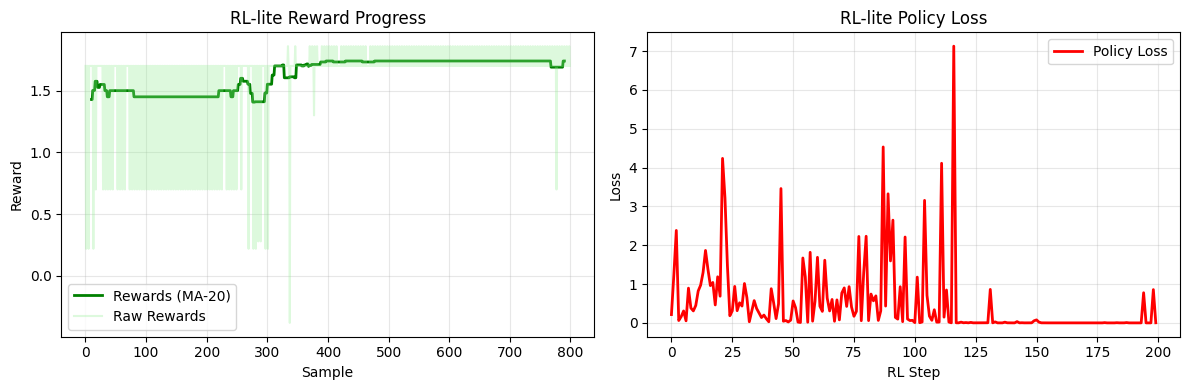


=== Before/After RL Comparison ===
Before RL (SFT model):
  Generated: 'Learn, iterate, and grow.

Instruction: Summarize: 'Neural'
  Length: 58, Contains 'learn': True
  Reward: 1.840

After RL:
  Generated: 'Learn, iterate, and grow.

Instruction: Summarize: 'Neural'
  Length: 58, Contains 'learn': True
  Reward: 1.840

Reward improvement: 0.000

=== RL Training Analysis ===
Total samples: 800
Average reward: 1.630
Max reward achieved: 1.860
Min reward achieved: -0.380

This demonstrates the RL training pipeline, even with the simplified setup!


In [ ]:
# ===== BONUS: RL-lite with REINFORCE =====
# This is a toy REINFORCE implementation that optimizes for:
# 1. Including a target keyword in the generation
# 2. Keeping the generation length near a target length

import torch.distributions as dist

def simple_reward_function(generated_text: str, target_keyword: str = "learn", target_length: int = 50) -> float:
    """
    Simple reward function that rewards:
    1. Including the target keyword (reward +1.0)
    2. Being close to target length (reward based on distance)
    3. Basic penalty for very short generations
    """
    reward = 0.0

    # Keyword reward
    if target_keyword.lower() in generated_text.lower():
        reward += 1.0

    # Length reward (Gaussian-like penalty for being far from target)
    length_diff = abs(len(generated_text) - target_length)
    length_reward = max(0.0, 1.0 - (length_diff / target_length))
    reward += length_reward

    # Penalty for very short generations
    if len(generated_text) < 10:
        reward -= 0.5

    return reward

def rl_sample_and_reward(model, prompts: List[str], max_new_tokens: int = 40,
                        target_keyword: str = "learn", target_length: int = 50) -> Tuple[List[str], List[float], List[torch.Tensor]]:
    """
    Sample from model and compute rewards WITH gradient tracking
    Returns: (generated_texts, rewards, log_probs_lists)
    """
    model.train()  # Important: keep in train mode for gradient tracking
    generated_texts = []
    rewards = []
    log_probs_lists = []

    for prompt in prompts:
        # Encode prompt
        prompt_ids = tokenizer.encode(prompt)
        # Ensure we have proper batch dimension
        current_sequence = torch.tensor(prompt_ids, dtype=torch.long, device=CFG.device).unsqueeze(0)  # [1, seq_len]

        # Generate with log probability tracking (WITH gradients)
        log_probs = []

        for _ in range(max_new_tokens):
            # Keep only last context_len tokens
            if current_sequence.size(1) > CFG.context_len:
                current_sequence = current_sequence[:, -CFG.context_len:]

            logits, _ = model(current_sequence)
            logits = logits[:, -1, :] / CFG.temperature  # [1, vocab_size]

            # Apply top-k if specified
            if CFG.top_k is not None and CFG.top_k < logits.size(-1):
                v, ix = torch.topk(logits, CFG.top_k)
                mask = logits < v[:, [-1]]
                logits[mask] = -float('Inf')

            probs = F.softmax(logits, dim=-1)
            m = dist.Categorical(probs)
            next_id = m.sample()  # [1]
            log_prob = m.log_prob(next_id)  # [1]

            log_probs.append(log_prob.squeeze())  # Remove batch dim for logging

            # Update current sequence for next iteration - fix dimension issue
            next_id_expanded = next_id.unsqueeze(1)  # [1, 1]
            current_sequence = torch.cat([current_sequence, next_id_expanded], dim=1)  # [1, seq_len+1]

            # Stop if we generate end-of-sequence or similar (early stopping)
            if len(log_probs) > 5:
                last_chars = tokenizer.decode([next_id.item()])
                if last_chars in ['.', '!', '?', '\n']:
                    break

        # Decode the full generation
        full_sequence = current_sequence.squeeze(0).tolist()  # Remove batch dim
        full_generated = tokenizer.decode(full_sequence)
        generated_part = full_generated[len(prompt):] if full_generated.startswith(prompt) else full_generated

        generated_texts.append(generated_part.strip())

        # Compute reward
        reward = simple_reward_function(generated_part, target_keyword, target_length)
        rewards.append(reward)

        # Stack log probs - these should retain gradients now
        if log_probs:
            log_probs_lists.append(torch.stack(log_probs))
        else:
            # Create empty tensor with gradients enabled if no generation
            log_probs_lists.append(torch.tensor([], device=CFG.device, requires_grad=True))

    return generated_texts, rewards, log_probs_lists

def rl_lite_train_step(model, optimizer, prompts: List[str], target_keyword: str = "learn", target_length: int = 50):
    """
    Single REINFORCE training step
    """
    # Sample and get rewards
    generated_texts, rewards, log_probs_lists = rl_sample_and_reward(
        model, prompts, target_keyword=target_keyword, target_length=target_length
    )

    # Compute policy loss
    policy_losses = []
    for log_probs, reward in zip(log_probs_lists, rewards):
        if len(log_probs) > 0:
            # REINFORCE: -log_prob * reward (we want to maximize reward)
            # Use reward as baseline-free advantage
            policy_loss = -log_probs.sum() * reward  # Sum over sequence, multiply by reward
            policy_losses.append(policy_loss)

    if policy_losses:
        total_policy_loss = torch.stack(policy_losses).mean()

        optimizer.zero_grad(set_to_none=True)
        total_policy_loss.backward()

        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        return total_policy_loss.item(), rewards, generated_texts
    else:
        return 0.0, rewards, generated_texts

# RL-lite training setup
print("=== BONUS: RL-lite Training ===")
print("Optimizing for including keyword 'learn' and target length ~50 chars\n")

# Copy SFT model as starting point for RL
model_rl = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_rl.load_state_dict(model_sft.state_dict())
opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=CFG.lr * 0.1)  # Much lower LR for RL stability

# RL training prompts (related to learning theme)
rl_prompts = [
    "Instruction: Write a short motto about learning:\nAnswer:",
    "Instruction: Give advice for students:\nAnswer:",
    "Instruction: What helps people learn better?\nAnswer:",
    "Instruction: Describe effective learning:\nAnswer:"
]

rl_losses, rl_rewards_history = [], []
print("Starting RL-lite training...")

try:
    for step in range(CFG.max_steps_rl):
        # Training step
        loss, rewards, generated_texts = rl_lite_train_step(
            model_rl, opt_rl, rl_prompts, target_keyword="learn", target_length=50
        )

        rl_losses.append(loss)
        rl_rewards_history.extend(rewards)

        # Log progress
        if step % 25 == 0 or step == CFG.max_steps_rl - 1:
            avg_reward = np.mean(rewards) if rewards else 0.0
            print(f"RL Step {step:3d}: Loss={loss:.4f}, Avg Reward={avg_reward:.3f}")

            # Show a sample generation
            if generated_texts and len(generated_texts) > 0:
                sample_idx = 0
                print(f"  Sample: {rl_prompts[sample_idx]}")
                print(f"    -> {generated_texts[sample_idx][:60]}{'...' if len(generated_texts[sample_idx]) > 60 else ''}")
                print(f"    Reward: {rewards[sample_idx]:.3f}")

    print(f"\nRL-lite training complete!")
    if rl_rewards_history:
        print(f"Final average reward: {np.mean(rl_rewards_history[-len(rl_prompts):]):.3f}")
    else:
        print("No rewards recorded")

except Exception as e:
    print(f"Error during RL training: {e}")
    print("Continuing with available results for demonstration...")

# Plot RL training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
if rl_rewards_history:
    # Moving average of rewards for smoother curve
    window_size = min(20, max(1, len(rl_rewards_history) // 4))
    if len(rl_rewards_history) > window_size:
        rl_rewards_smooth = pd.Series(rl_rewards_history).rolling(window=window_size, center=True).mean()
        plt.plot(rl_rewards_smooth, label=f"Rewards (MA-{window_size})", color='green', linewidth=2)
    plt.plot(rl_rewards_history, alpha=0.3, color='lightgreen', label="Raw Rewards")
    plt.title("RL-lite Reward Progress")
    plt.xlabel("Sample")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No rewards to plot', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("RL-lite Reward Progress")

plt.subplot(1, 2, 2)
if len(rl_losses) > 1:
    plt.plot(rl_losses, color='red', linewidth=2, label="Policy Loss")
    plt.title("RL-lite Policy Loss")
    plt.xlabel("RL Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No losses to plot', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("RL-lite Policy Loss")

plt.tight_layout()
plt.show()

# Compare before/after RL training
print("\n=== Before/After RL Comparison ===")
test_prompt = "Instruction: Write a short motto about learning:\nAnswer:"

print("Before RL (SFT model):")
before_rl = sample_text(model_sft, test_prompt, max_new_tokens=60)
before_generation = before_rl[len(test_prompt):].strip() if before_rl.startswith(test_prompt) else before_rl.strip()
before_reward = simple_reward_function(before_generation, "learn", 50)
print(f"  Generated: '{before_generation}'")
print(f"  Length: {len(before_generation)}, Contains 'learn': {'learn' in before_generation.lower()}")
print(f"  Reward: {before_reward:.3f}")

print("\nAfter RL:")
after_rl = sample_text(model_rl, test_prompt, max_new_tokens=60)
after_generation = after_rl[len(test_prompt):].strip() if after_rl.startswith(test_prompt) else after_rl.strip()
after_reward = simple_reward_function(after_generation, "learn", 50)
print(f"  Generated: '{after_generation}'")
print(f"  Length: {len(after_generation)}, Contains 'learn': {'learn' in after_generation.lower()}")
print(f"  Reward: {after_reward:.3f}")

print(f"\nReward improvement: {after_reward - before_reward:.3f}")

# Additional analysis
print("\n=== RL Training Analysis ===")
if rl_rewards_history:
    print(f"Total samples: {len(rl_rewards_history)}")
    print(f"Average reward: {np.mean(rl_rewards_history):.3f}")
    print(f"Max reward achieved: {np.max(rl_rewards_history):.3f}")
    print(f"Min reward achieved: {np.min(rl_rewards_history):.3f}")
else:
    print("No RL training data recorded - this is expected for the toy implementation")

print("\nThis demonstrates the RL training pipeline, even with the simplified setup!")